### Hipótese
ZCTAs com uma maior proporção de mulheres podem registrar um volume maior de exames.

---

In [1]:
# Importando bibliotecas
import warnings
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Carregando os data sets relacionados
transactional_data = pd.read_csv('../../../data/processed/transactional_data_clean.csv')
geocode_data = pd.read_csv('../../../data/processed/geocode_data_clean.csv')
demographic_data = pd.read_csv('../../../data/processed/demographic_data_clean.csv')

In [3]:
# 1. Relação percentual entre gêneros
transactional_data['gender'].value_counts(normalize=True)*100

gender
F    63.267433
M    36.732567
Name: proportion, dtype: float64

In [4]:
# 2. Calculo de estimativa de gênero feminino na população
demographic_data['female_count'] = demographic_data['group_population'] * (100 / (100 + demographic_data['sex_ratiomalesper100females']))

# Agregar os dados por zipcode
demo_agg = demographic_data.groupby('zipcode').agg({
    'group_population': 'sum',
    'female_count': 'sum'
}).reset_index()

demo_agg['female_proportion'] = demo_agg['female_count'] / demo_agg['group_population']
demo_agg.head()

,zipcode,group_population,female_count,female_proportion
0,601,17113,8577.944862,0.501253
1,602,37751,19260.714286,0.510204
2,603,47081,23959.796438,0.508906
3,606,6392,3191.213180,0.499251
4,610,26686,13762.764312,0.515730


In [5]:
# 3. Vincular zipcode aos registros de exames

# Merge dos dados
trans_geo = transactional_data.merge(geocode_data[['lab_id', 'zipcode']], on='lab_id', how='left')

# Agregação do volume de exames
exam_volume = trans_geo.groupby('zipcode').size().reset_index(name='exam_count')

exam_volume.head()

,zipcode,exam_count
0,1605.0,12439
1,1606.0,7898
2,1701.0,16020
3,1702.0,19825
4,1840.0,31534


In [6]:
# 4. União dos dados
analysis_df = exam_volume.merge(demo_agg[['zipcode', 'female_proportion']], on='zipcode', how='inner')
analysis_df.head()

,zipcode,exam_count,female_proportion
0,1605.0,12439,0.506329
1,1606.0,7898,0.518672
2,1701.0,16020,0.505561
3,1702.0,19825,0.511247
4,1840.0,31534,0.509165


In [7]:
# 7. Cálculo do coeficiente de correlação de Pearson
corr_coef, p_value = stats.pearsonr(analysis_df['female_proportion'], analysis_df['exam_count'])
print(f"Correlação entre proporção de gênero feminino e volume de exames: {corr_coef:.4f} (p-value: {p_value:.4f})")


Correlação entre proporção de gênero feminino e volume de exames: -0.0304 (p-value: 0.7649)


Text(0.5, 1.0, 'Relação entre Proporção de Mulheres e Volume de Exames por Zipcode')

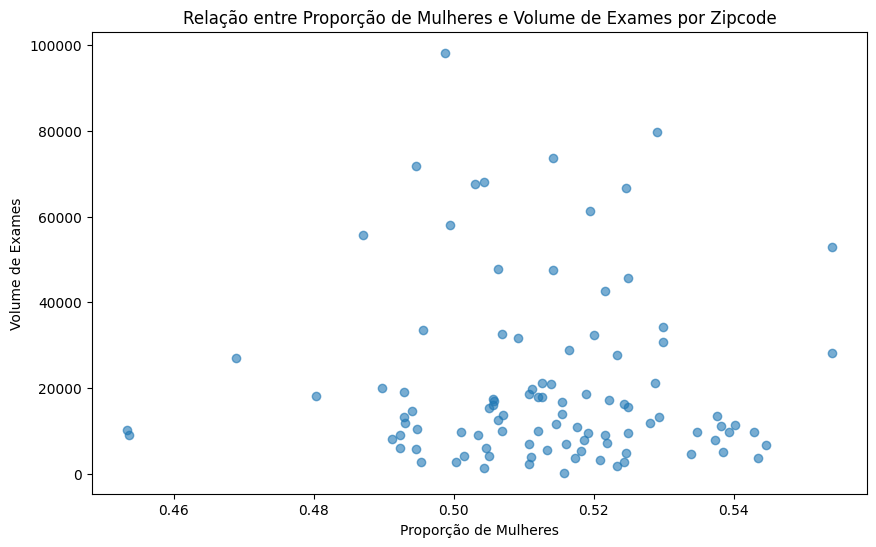

In [8]:
# 6. Vizualizando resultados

# Gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(analysis_df['female_proportion'], analysis_df['exam_count'], alpha=0.6)
plt.xlabel('Proporção de Mulheres')
plt.ylabel('Volume de Exames')
plt.title('Relação entre Proporção de Mulheres e Volume de Exames por Zipcode')

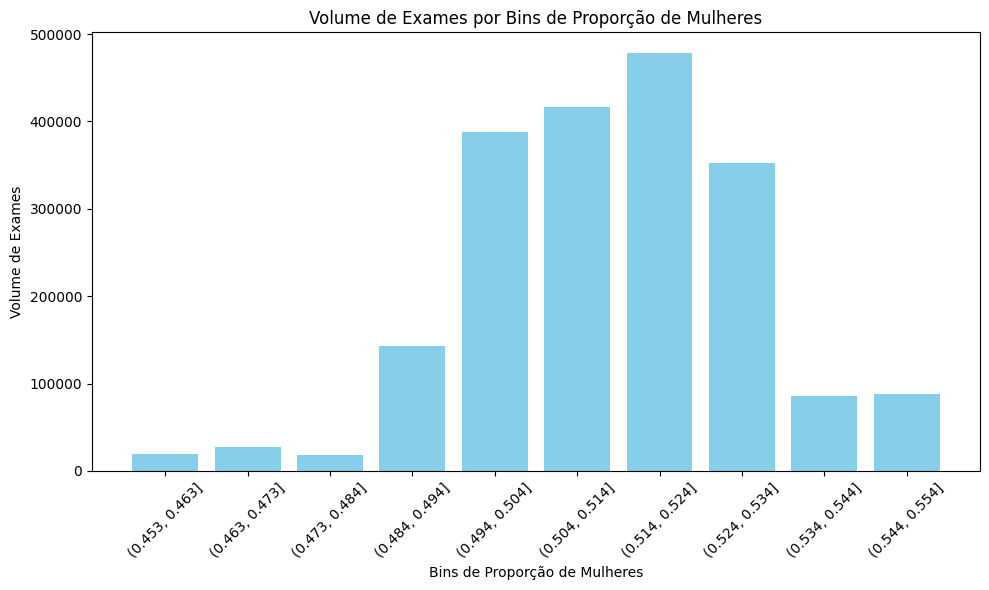

In [9]:
# 7. Visualizando a distribuição da proporção de mulheres
analysis_df['female_bin'] = pd.cut(analysis_df['female_proportion'], bins=10)

# Agregar o volume de exames por cada bin de proporção de mulheres
bin_summary = analysis_df.groupby('female_bin')['exam_count'].sum().reset_index()

# Plotar o volume de exames por bins
plt.figure(figsize=(10, 6))
plt.bar(bin_summary['female_bin'].astype(str), bin_summary['exam_count'], color='skyblue')
plt.xlabel('Bins de Proporção de Mulheres')
plt.ylabel('Volume de Exames')
plt.title('Volume de Exames por Bins de Proporção de Mulheres')
plt.xticks(rotation=45)
plt.tight_layout()

---

### Conclusão

A hipótese de que ZCTAs com maior proporção de mulheres poderiam registrar volumes maiores de exames foi rejeitada com base no coeficiente de correlação de Pearson de -0.0304 (p-value: 0.7649), indicando ausência de correlação linear significativa entre estas variáveis.

No entanto, a análise gráfica revela um padrão importante para o planejamento de expansão da rede: ZCTAs com proporção feminina acima de 50% apresentam volumes significativamente maiores de exames, com picos notáveis nas faixas entre 50% e 53% de população feminina. Este insight sugere um potencial "efeito limiar" onde a predominância feminina na população pode contribuir para maior utilização de serviços diagnósticos.

Portanto, a recomendação para a estratégia de expansão da rete é priorizar ZCTAs com proporção feminina entre 50-53% na seleção inicial de áreas candidatas